# Anand Mysorekar

## Cogs 118a Final Project

# Abstract

This project evaluates the performance of three classification models—Random Forest, Support Vector Machine (SVM), and Logistic Regression—on three datasets from the UCI Machine Learning Repository. Each dataset is structured for binary classification, and the models are trained using hyperparameter tuning and evaluated under varying data partitions (20/80, 50/50, 80/20 splits). Metrics such as training, validation, and test accuracy are used to compare the models' effectiveness. Results show that Random Forest consistently achieves the highest accuracy across datasets, while SVM and Logistic Regression demonstrate varying strengths depending on the data's complexity and feature distribution. This study highlights the importance of selecting appropriate classifiers and hyperparameters for different datasets and provides insights into model behavior under different training-to-testing ratios.



# Introduction

Classification is a fundamental task in machine learning, where the goal is to assign inputs to predefined categories. Binary classification, in particular, has widespread applications such as identifying spam emails, diagnosing medical conditions, and predicting customer churn. Selecting the appropriate classification model is critical for achieving high accuracy and robustness across different datasets.

The performance of a classifier often depends on the dataset's characteristics, such as the number of features, the size of the training set, and the feature distributions. Comparing multiple classifiers on the same datasets provides insights into their strengths, weaknesses, and generalizability.

This project aims to evaluate and compare the performance of three popular classification models on three classification datasets. By exploring their behavior under different training/testing splits and tuning hyperparameters, this study seeks to identify general trends and best practices in classifier selection.

# Data Preprocessing

## Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

## Dataset 1: [Adult](http://archive.ics.uci.edu/dataset/2/adult)
Predicting whether annual income of an individual exceeds $50K/yr based on census data. 48,842 instances, 14 features.


### Load data and assign column names

In [17]:
column_names = [
    "age",
    "class",
    "fnlwgt", # drop
    "education_level",
    "education-num", # drop
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gains",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "salary"
]


adult_dataset = pd.read_csv('adult_dataset/adult.data', names=column_names) # read the dataset
adult_dataset = adult_dataset.drop(columns=["fnlwgt", "education-num"]) # drop these columns
adult_dataset = adult_dataset[~adult_dataset.map(lambda x: str(x).strip()).isin(['?']).any(axis=1)] # remove rows with missing values

print(adult_dataset.dtypes)
adult_dataset.head()

age                 int64
class              object
education_level    object
marital_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gains       int64
capital_loss        int64
hours_per_week      int64
native_country     object
salary             object
dtype: object


,age,class,education_level,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Most of the features are categorical, so we will need to encode them before training the models. Many of the features have lots of possible values, so we will group them into fewer categories to reduce the dimensionality of the data.


### Group similar values for dimensionality reduction for effecient encoding

In [18]:
class_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Federal-gov': 'Government',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

adult_dataset['class'] = adult_dataset['class'].str.strip()
adult_dataset['class'] = adult_dataset['class'].map(class_mapping)
print(adult_dataset['class'].unique())


education_mapping = {
    'Bachelors': 'Undergraduate',
    'Some-college': 'Undergraduate',
    'Assoc-acdm': 'Undergraduate',
    'Assoc-voc': 'Undergraduate',
    'Masters': 'Postgraduate',
    'Doctorate': 'Postgraduate',
    'Prof-school': 'Postgraduate',
    'HS-grad': 'Lower Education',
    '12th': 'Lower Education',
    '11th': 'Lower Education',
    '10th': 'Lower Education',
    '9th': 'Lower Education',
    '7th-8th': 'Lower Education',
    '5th-6th': 'Lower Education',
    '1st-4th': 'Lower Education',
    'Preschool': 'Lower Education'
}

adult_dataset['education_level'] = adult_dataset['education_level'].str.strip()
adult_dataset['education_level'] = adult_dataset['education_level'].map(education_mapping)
print(adult_dataset['education_level'].unique())


marital_mapping = {
    'Never-married': 'Single',
    'Married-civ-spouse': 'Married',
    'Married-AF-spouse': 'Married',
    'Divorced': 'Previously Married',
    'Separated': 'Previously Married',
    'Widowed': 'Previously Married',
    'Married-spouse-absent': 'Married'
}

adult_dataset['marital_status'] = adult_dataset['marital_status'].str.strip()
adult_dataset['marital_status'] = adult_dataset['marital_status'].map(marital_mapping)
print(adult_dataset['marital_status'].unique())


occupation_mapping = {
    'Tech-support': 'White-collar',
    'Craft-repair': 'Blue-collar',
    'Other-service': 'Service',
    'Sales': 'White-collar',
    'Exec-managerial': 'White-collar',
    'Prof-specialty': 'White-collar',
    'Handlers-cleaners': 'Blue-collar',
    'Machine-op-inspct': 'Blue-collar',
    'Adm-clerical': 'White-collar',
    'Farming-fishing': 'Blue-collar',
    'Transport-moving': 'Blue-collar',
    'Priv-house-serv': 'Service',
    'Protective-serv': 'Service',
    'Armed-Forces': 'Military'
}

adult_dataset['occupation'] = adult_dataset['occupation'].str.strip()
adult_dataset['occupation'] = adult_dataset['occupation'].map(occupation_mapping)
print(adult_dataset['occupation'].unique())


relationship_mapping = {
    'Wife': 'Spouse',
    'Husband': 'Spouse',
    'Own-child': 'Dependent',
    'Not-in-family': 'Unrelated',
    'Other-relative': 'Dependent',
    'Unmarried': 'Unrelated'
}

adult_dataset['relationship'] = adult_dataset['relationship'].str.strip()
adult_dataset['relationship'] = adult_dataset['relationship'].map(relationship_mapping)
print(adult_dataset['relationship'].unique())


race_mapping = {
    'White': 'White',
    'Black': 'Black',
    'Asian-Pac-Islander': 'Asian',
    'Amer-Indian-Eskimo': 'Indigenous',
    'Other': 'Other'
}

adult_dataset['race'] = adult_dataset['race'].str.strip()
adult_dataset['race'] = adult_dataset['race'].map(race_mapping)
print(adult_dataset['race'].unique())


sex_mapping = {
    'Male': 1,
    'Female': 0
}

adult_dataset['sex'] = adult_dataset['sex'].str.strip()
adult_dataset['sex'] = adult_dataset['sex'].map(sex_mapping)
print(adult_dataset['sex'].unique())


country_mapping = {
    'United-States': 'North America',
    'Canada': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'North America',
    'Puerto-Rico': 'North America',
    'Mexico': 'Latin America',
    'Cuba': 'Latin America',
    'Dominican-Republic': 'Latin America',
    'Jamaica': 'Latin America',
    'Haiti': 'Latin America',
    'Trinadad&Tobago': 'Latin America',
    'El-Salvador': 'Latin America',
    'Guatemala': 'Latin America',
    'Honduras': 'Latin America',
    'Nicaragua': 'Latin America',
    'Ecuador': 'Latin America',
    'Peru': 'Latin America',
    'Columbia': 'Latin America',
    'England': 'Europe',
    'Germany': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Ireland': 'Europe',
    'France': 'Europe',
    'Greece': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',
    'Cambodia': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'China': 'Asia',
    'Philippines': 'Asia',
    'Vietnam': 'Asia',
    'Laos': 'Asia',
    'Thailand': 'Asia',
    'Hong': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Middle East',
    'South': 'Other',
    'Israel': 'Middle East',  
    'Other': 'Other'
}

adult_dataset['native_country'] = adult_dataset['native_country'].str.strip()
adult_dataset['native_country'] = adult_dataset['native_country'].map(country_mapping)
print(adult_dataset['native_country'].unique())


salary_mapping = {
    '>50K': 1,
    '<=50K': 0
}

adult_dataset['salary'] = adult_dataset['salary'].str.strip()
adult_dataset['salary'] = adult_dataset['salary'].map(salary_mapping)
print(adult_dataset['salary'].unique())

['Government' 'Self-employed' 'Private' 'Other']
['Undergraduate' 'Lower Education' 'Postgraduate']
['Single' 'Married' 'Previously Married']
['White-collar' 'Blue-collar' 'Service' 'Military']
['Unrelated' 'Spouse' 'Dependent']
['White' 'Black' 'Asian' 'Indigenous' 'Other']
[1 0]
['North America' 'Latin America' 'Asia' 'Europe' 'Middle East' 'Other']
[0 1]


In [19]:
adult_dataset.head()

,age,class,education_level,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,salary
0,39,Government,Undergraduate,Single,White-collar,Unrelated,White,1,2174,0,40,North America,0
1,50,Self-employed,Undergraduate,Married,White-collar,Spouse,White,1,0,0,13,North America,0
2,38,Private,Lower Education,Previously Married,Blue-collar,Unrelated,White,1,0,0,40,North America,0
3,53,Private,Lower Education,Married,Blue-collar,Spouse,Black,1,0,0,40,North America,0
4,28,Private,Undergraduate,Married,White-collar,Spouse,Black,0,0,0,40,Latin America,0


That looks much better and much more manageable. Now we can encode the data. Most of the features are nominal, meaning they don't have an inherent order, so we will use one-hot encoding to encode them. The education level variable, however, is ordinal (meaning there is some order, but the distances between them don't necessarily mean anything), so we will use label encoding for that variable.

### Encode categorical variables

In [20]:
columns_to_one_hot = ['class', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
adult_dataset = pd.get_dummies(adult_dataset, columns=columns_to_one_hot, prefix=columns_to_one_hot)

label_encoder = LabelEncoder()
adult_dataset['education_level'] = label_encoder.fit_transform(adult_dataset['education_level'])


In [21]:
print(adult_dataset.dtypes)
adult_dataset.head()


age                                  int64
education_level                      int64
sex                                  int64
capital_gains                        int64
capital_loss                         int64
hours_per_week                       int64
salary                               int64
class_Government                      bool
class_Other                           bool
class_Private                         bool
class_Self-employed                   bool
marital_status_Married                bool
marital_status_Previously Married     bool
marital_status_Single                 bool
occupation_Blue-collar                bool
occupation_Military                   bool
occupation_Service                    bool
occupation_White-collar               bool
relationship_Dependent                bool
relationship_Spouse                   bool
relationship_Unrelated                bool
race_Asian                            bool
race_Black                            bool
race_Indige

,age,education_level,sex,capital_gains,capital_loss,hours_per_week,salary,class_Government,class_Other,class_Private,...,race_Black,race_Indigenous,race_Other,race_White,native_country_Asia,native_country_Europe,native_country_Latin America,native_country_Middle East,native_country_North America,native_country_Other
0,39,2,1,2174,0,40,0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
1,50,2,1,0,0,13,0,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,38,0,1,0,0,40,0,False,False,True,...,False,False,False,True,False,False,False,False,True,False
3,53,0,1,0,0,40,0,False,False,True,...,True,False,False,False,False,False,False,False,True,False
4,28,2,0,0,0,40,0,False,False,True,...,True,False,False,False,False,False,True,False,False,False


Now that each feature is in the format a machine can handle and intepret properly, the data is ready for modeling!

## Dataset 2: [Heart Disease](http://archive.ics.uci.edu/dataset/45/heart+disease)
Heart disease dataset from four databases predicting if a person has heart disease based on various features. 3 of the databases were riddled with missing values, so we will use the Cleveland database. 303 instances, 14 features.


### Load data and assign column names


In [22]:
column_names = ["age", "sex", "cp", "resting_bp", "cholesterol", "blood_sugar", "resting_ekg", "max_hr", "exang", "oldpeak", "slope", "ca", "thal", "severity"]


heart_dataset = pd.read_csv('heart_dataset/processed.cleveland.data', header=None, names=column_names) # read the dataset
heart_dataset = heart_dataset[~heart_dataset.map(lambda x: str(x).strip()).isin(['?']).any(axis=1)] # remove rows with missing values
heart_dataset['ca'] = heart_dataset['ca'].astype(float) # convert to float
heart_dataset['thal'] = heart_dataset['thal'].astype(float) # convert to float
heart_dataset['severity'] = heart_dataset['severity'].apply(lambda x: 0 if x == 0 else 1) # convert to binary for 2 class classification

print(heart_dataset.dtypes)
heart_dataset.head()

age            float64
sex            float64
cp             float64
resting_bp     float64
cholesterol    float64
blood_sugar    float64
resting_ekg    float64
max_hr         float64
exang          float64
oldpeak        float64
slope          float64
ca             float64
thal           float64
severity         int64
dtype: object


,age,sex,cp,resting_bp,cholesterol,blood_sugar,resting_ekg,max_hr,exang,oldpeak,slope,ca,thal,severity
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


This dataset is already clean and ready for modeling, so we are done!

## Dataset 3:
Wine dataset; predicting the quality of wine based on various features.


### Load data and assign column names

Since the qualities of a good red wine might be different from those of a good white wine, I will split the dataset into two and model them separately, as well as model the combined dataset.

In [23]:
red_wine_dataset = pd.read_csv('wine_dataset/winequality-red.csv', sep=';') # read the dataset
white_wine_dataset = pd.read_csv('wine_dataset/winequality-white.csv', sep=';') # read the dataset
red_white_wine_dataset = pd.concat([red_wine_dataset, white_wine_dataset], axis=0) # concatenate the datasets
wine_datasets = [red_wine_dataset, white_wine_dataset, red_white_wine_dataset] 

for i, dataset in enumerate(wine_datasets, start=1):
    dataset['quality'] = dataset['quality'].apply(lambda x: 0 if x <= 6 else 1) # convert to binary for 2 class classification

In [24]:
print(red_wine_dataset.dtypes)
red_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [25]:
print(red_wine_dataset.dtypes)
white_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


In [26]:
print(red_white_wine_dataset.dtypes)
red_white_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


This dataset is already clean and ready for modeling. 

# Methods and Models

I am going to use the following models for each dataset: Support Vector Machine, Random Forest, and Logistic Regression. For each of the models I will:

- Preprocess the data
    - Scale the data using StandardScaler to standardize the input values for better model performance
    - Separate the data into features and target column

- Partition the data into training and testing sets
    - Use 20/80, 50/50, and 80/20 splits to evaluate model performance under different training/testing ratios

- Perform hyperparameter tuning using GridSearchCV
    - Tune the hyperparameters for each model to optimize performance

- Train the model
    - Fit the model on the training data for each partition using the best hyperparameters

- Evaluate the model
    - Evaluate the model using cross scores to compute the average validation accuracy
    - Evaluate the model on the test set to compute the test accuracy
    - Generate classification reports to analyze precision, recall, and F1 scores



## Support Vector Machine 

In [27]:
def train_svm_with_partitions(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions (test/train split ratios)
    partitions = {
        "20/80": 0.2,
        "50/50": 0.5,
        "80/20": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        print(f"\nTraining with {partition_name} partition...")
        
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Define hyperparameter grid
        param_grid = {
            'C': [0.1, 1, 10, 100], 
            'gamma': ['scale', 0.1],  
            'kernel': ['rbf']
        }

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        
        # Evaluate cross-validation accuracy on training set
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
        avg_cv_score = np.mean(cv_scores)
        print(f"Average cross-validation accuracy: {avg_cv_score:.2f}")
        
        # Evaluate on test set
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"Test accuracy: {test_accuracy:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store results
        results.append({
            "Partition": partition_name,
            "CV Accuracy": avg_cv_score,
            "Test Accuracy": test_accuracy
        })
        
        # Visualize confusion matrix
        ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
        plt.title(f"Confusion Matrix: {partition_name} Partition")
        plt.show()

    # Display summarized results
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(results_df)
    
    # Plot training vs. testing accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(results_df["Partition"], results_df["CV Accuracy"], label="Validation Accuracy", marker='o')
    plt.plot(results_df["Partition"], results_df["Test Accuracy"], label="Test Accuracy", marker='o')
    plt.xlabel("Partition")
    plt.ylabel("Accuracy")
    plt.title("SVM Performance Across Partitions")
    plt.legend()
    plt.grid()
    plt.show()

## Random Forest

In [28]:
def train_random_forest_with_partitions(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions
    partitions = {
        "20/80": 0.2,
        "50/50": 0.5,
        "80/20": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        print(f"\nTraining with {partition_name} partition...")
        
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Define hyperparameter grid
        param_grid = {
            'n_estimators': [50, 100, 200],  
            'max_depth': [None, 10, 20], 
            'min_samples_split': [2, 5, 10],
            'bootstrap': [True, False]
        }

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        
        # Evaluate cross-validation accuracy on training set
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
        avg_cv_score = np.mean(cv_scores)
        print(f"Average cross-validation accuracy: {avg_cv_score:.2f}")
        
        # Evaluate on test set
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"Test accuracy: {test_accuracy:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store results
        results.append({
            "Partition": partition_name,
            "CV Accuracy": avg_cv_score,
            "Test Accuracy": test_accuracy
        })
        
        # Visualize confusion matrix
        ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
        plt.title(f"Confusion Matrix: {partition_name} Partition")
        plt.show()

    # Display summarized results
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(results_df)
    
    # Plot training vs. testing accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(results_df["Partition"], results_df["CV Accuracy"], label="Validation Accuracy", marker='o')
    plt.plot(results_df["Partition"], results_df["Test Accuracy"], label="Test Accuracy", marker='o')
    plt.xlabel("Partition")
    plt.ylabel("Accuracy")
    plt.title("Random Forest Performance Across Partitions")
    plt.legend()
    plt.grid()
    plt.show()

## Logistic Regression

In [29]:
def train_logistic_regression_with_partitions(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions
    partitions = {
        "20/80": 0.2,
        "50/50": 0.5,
        "80/20": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        print(f"\nTraining with {partition_name} partition...")
        
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Define hyperparameter grid
        param_grid = {
            'C': [0.1, 1, 10, 100],  
            'penalty': ['l1', 'l2'],  
            'solver': ['liblinear', 'saga'] ,
            'fit_intercept': [True, False]
        }

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        
        # Evaluate cross-validation accuracy on training set
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
        avg_cv_score = np.mean(cv_scores)
        print(f"Average cross-validation accuracy: {avg_cv_score:.2f}")
        
        # Evaluate on test set
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"Test accuracy: {test_accuracy:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store results
        results.append({
            "Partition": partition_name,
            "CV Accuracy": avg_cv_score,
            "Test Accuracy": test_accuracy
        })
        
        # Visualize confusion matrix
        ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
        plt.title(f"Confusion Matrix: {partition_name} Partition")
        plt.show()

    # Display summarized results
    results_df = pd.DataFrame(results)
    print("\nSummary of Results:")
    print(results_df)
    
    # Plot training vs. testing accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(results_df["Partition"], results_df["CV Accuracy"], label="Validation Accuracy", marker='o')
    plt.plot(results_df["Partition"], results_df["Test Accuracy"], label="Test Accuracy", marker='o')
    plt.xlabel("Partition")
    plt.ylabel("Accuracy")
    plt.title("Logistic Regression Performance Across Partitions")
    plt.legend()
    plt.grid()
    plt.show()

# Experiments

### Running SVM on all the datasets

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4503
           1       0.75      0.62      0.68      1530

    accuracy                           0.85      6033
   macro avg       0.82      0.77      0.79      6033
weighted avg       0.85      0.85      0.85      6033



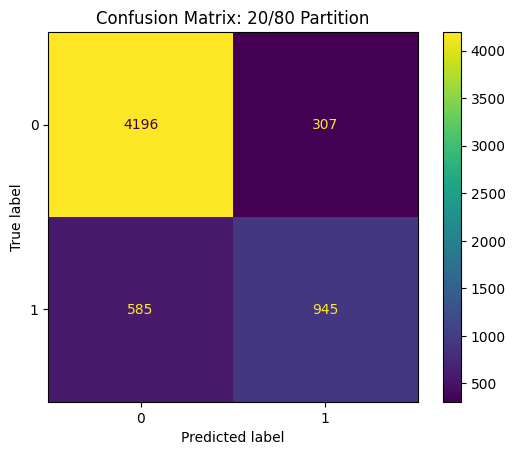


Training with 50/50 partition...
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11287
           1       0.74      0.61      0.67      3794

    accuracy                           0.85     15081
   macro avg       0.81      0.77      0.78     15081
weighted avg       0.84      0.85      0.84     15081



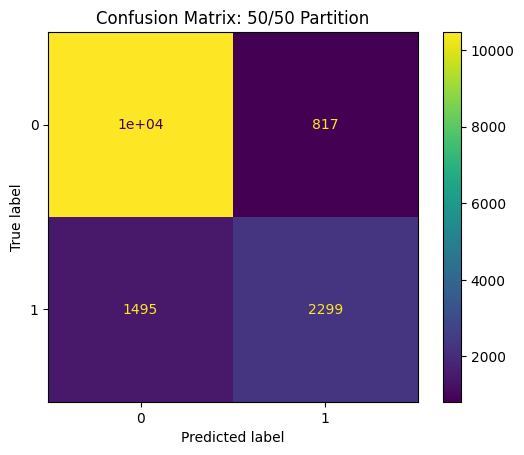


Training with 80/20 partition...
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18144
           1       0.71      0.61      0.66      5986

    accuracy                           0.84     24130
   macro avg       0.80      0.76      0.78     24130
weighted avg       0.84      0.84      0.84     24130



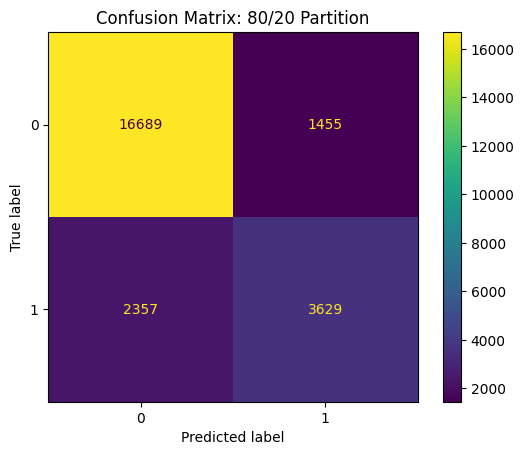


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.843508       0.852147
1     50/50     0.843379       0.846695
2     80/20     0.835211       0.842022


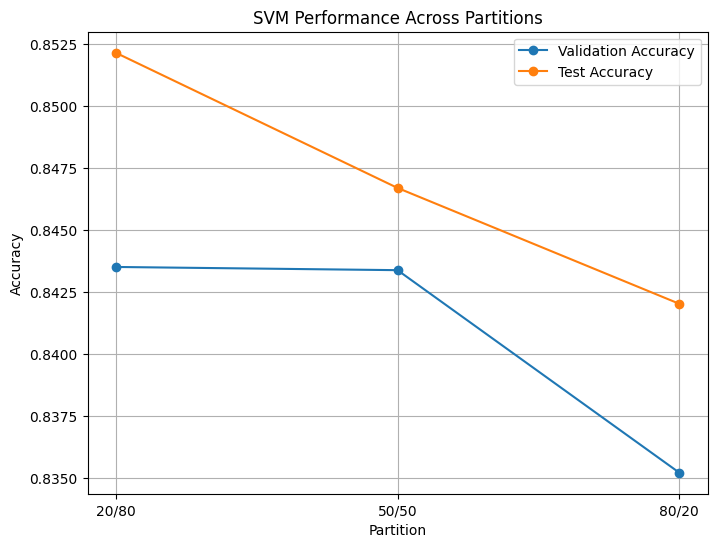


Training on 'Heart Dataset' with target column 'severity'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        36
           1       0.88      0.88      0.88        24

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



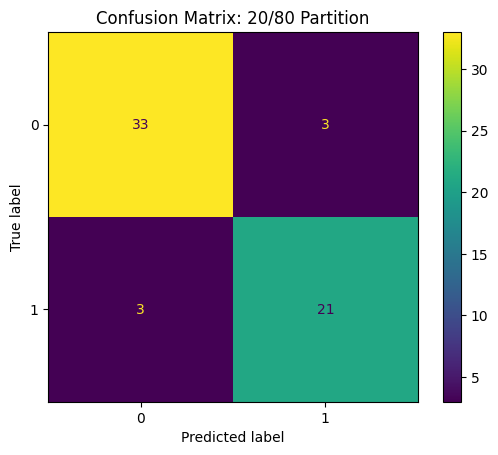


Training with 50/50 partition...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78        70
           1       0.85      0.70      0.76        79

    accuracy                           0.77       149
   macro avg       0.78      0.78      0.77       149
weighted avg       0.78      0.77      0.77       149



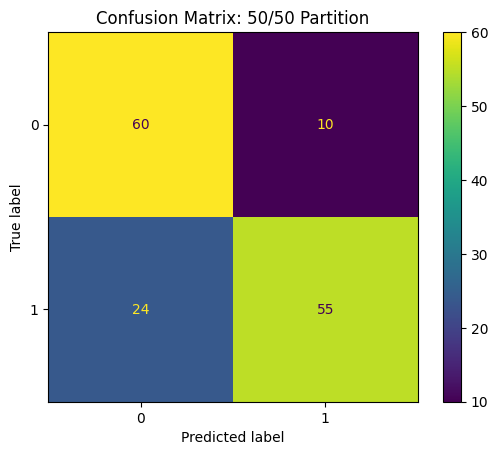


Training with 80/20 partition...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.78
Test accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77       121
           1       0.85      0.55      0.67       117

    accuracy                           0.73       238
   macro avg       0.76      0.73      0.72       238
weighted avg       0.76      0.73      0.72       238



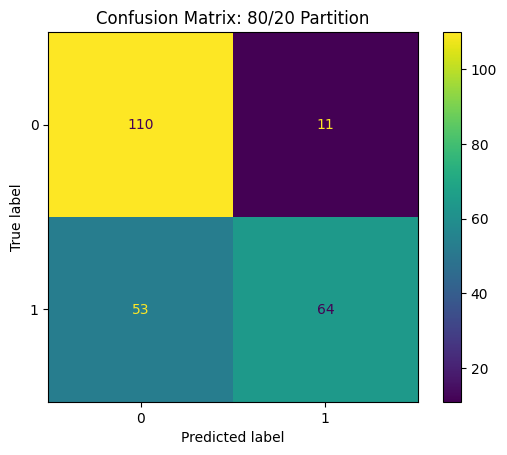


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.835372       0.900000
1     50/50     0.817011       0.771812
2     80/20     0.777273       0.731092


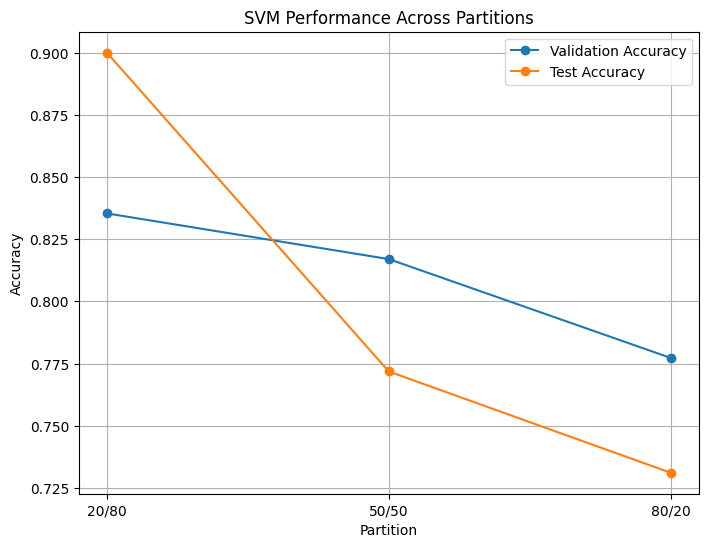


Training on 'Red Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.90
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       273
           1       0.66      0.53      0.59        47

    accuracy                           0.89       320
   macro avg       0.79      0.74      0.76       320
weighted avg       0.88      0.89      0.89       320



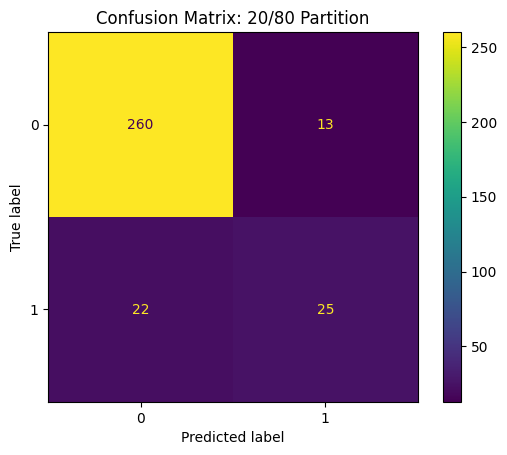


Training with 50/50 partition...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.89
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       688
           1       0.78      0.26      0.39       112

    accuracy                           0.89       800
   macro avg       0.84      0.62      0.66       800
weighted avg       0.88      0.89      0.86       800



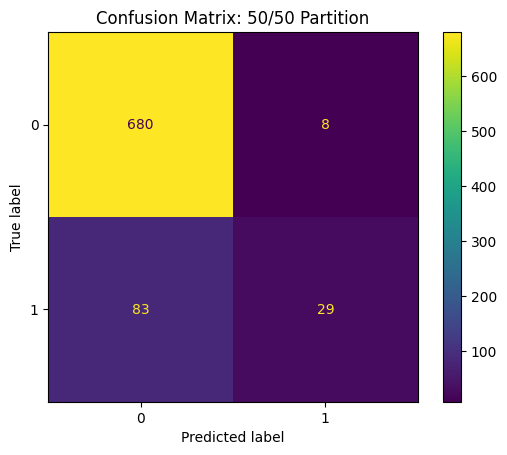


Training with 80/20 partition...
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.90
Test accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1102
           1       0.69      0.21      0.33       178

    accuracy                           0.88      1280
   macro avg       0.79      0.60      0.63      1280
weighted avg       0.86      0.88      0.85      1280



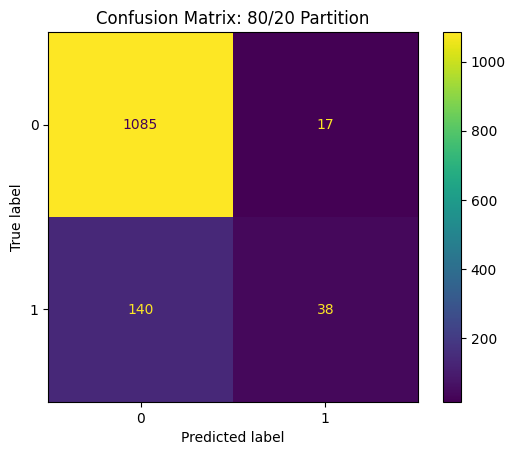


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.896011       0.890625
1     50/50     0.893632       0.886250
2     80/20     0.899702       0.877344


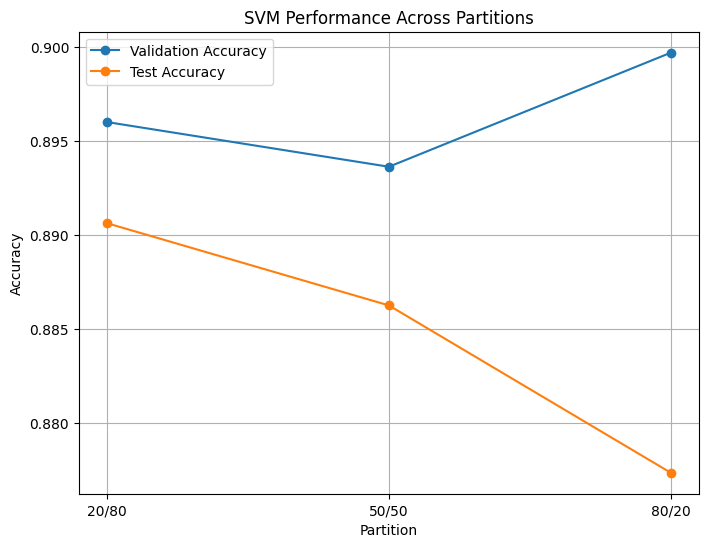


Training on 'White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.83
Test accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       753
           1       0.74      0.49      0.59       227

    accuracy                           0.84       980
   macro avg       0.80      0.72      0.75       980
weighted avg       0.83      0.84      0.83       980



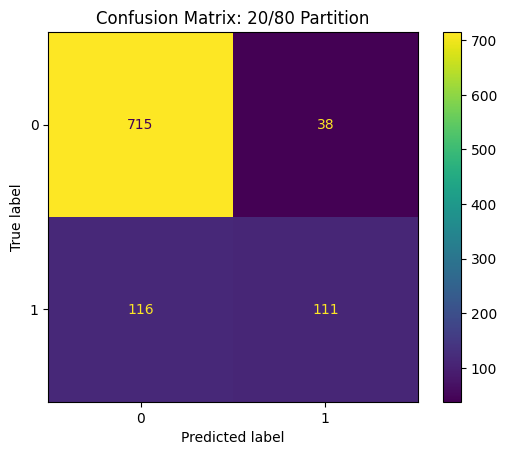


Training with 50/50 partition...
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.83
Test accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1888
           1       0.69      0.42      0.52       561

    accuracy                           0.82      2449
   macro avg       0.77      0.68      0.71      2449
weighted avg       0.81      0.82      0.81      2449



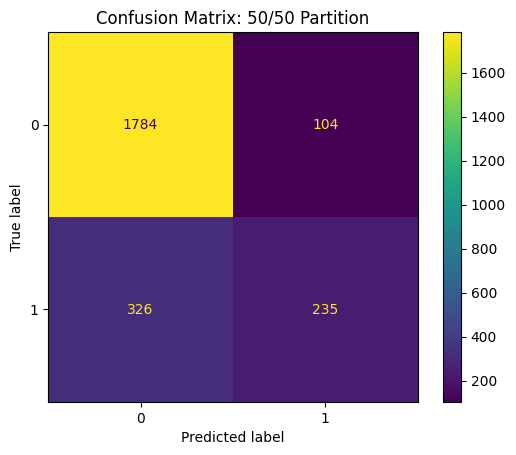


Training with 80/20 partition...
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3055
           1       0.59      0.40      0.48       864

    accuracy                           0.81      3919
   macro avg       0.72      0.66      0.68      3919
weighted avg       0.79      0.81      0.79      3919



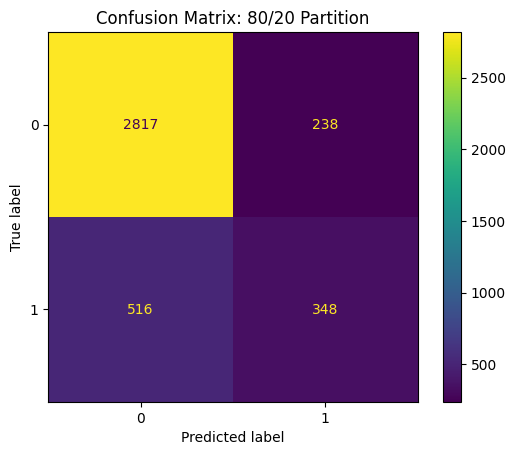


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.832568       0.842857
1     50/50     0.831372       0.824418
2     80/20     0.822334       0.807604


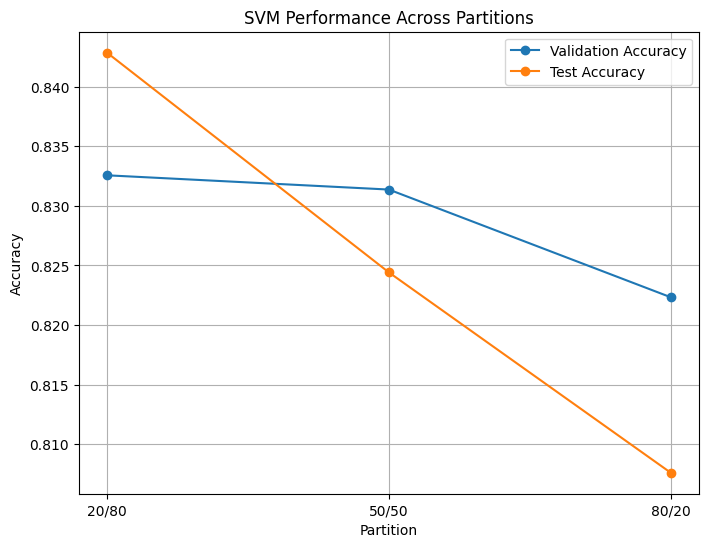


Training on 'Red and White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.85
Test accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1048
           1       0.69      0.52      0.59       252

    accuracy                           0.86      1300
   macro avg       0.79      0.73      0.76      1300
weighted avg       0.85      0.86      0.85      1300



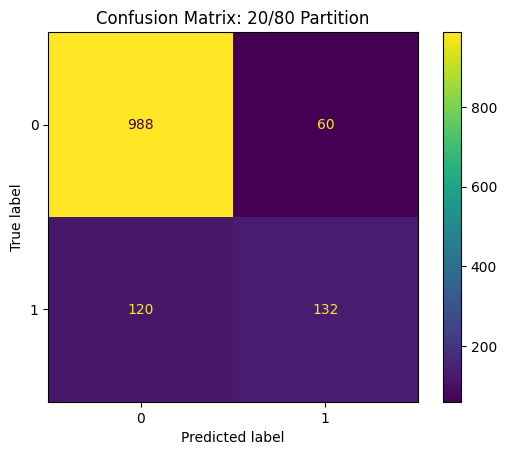


Training with 50/50 partition...
Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2613
           1       0.57      0.47      0.52       636

    accuracy                           0.83      3249
   macro avg       0.72      0.69      0.70      3249
weighted avg       0.82      0.83      0.82      3249



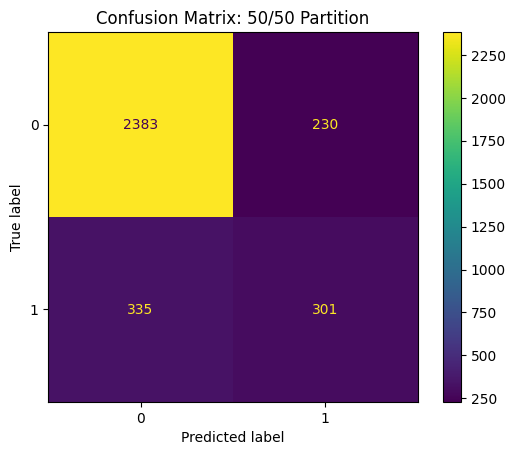


Training with 80/20 partition...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Average cross-validation accuracy: 0.83
Test accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4169
           1       0.70      0.17      0.27      1029

    accuracy                           0.82      5198
   macro avg       0.76      0.58      0.59      5198
weighted avg       0.80      0.82      0.77      5198



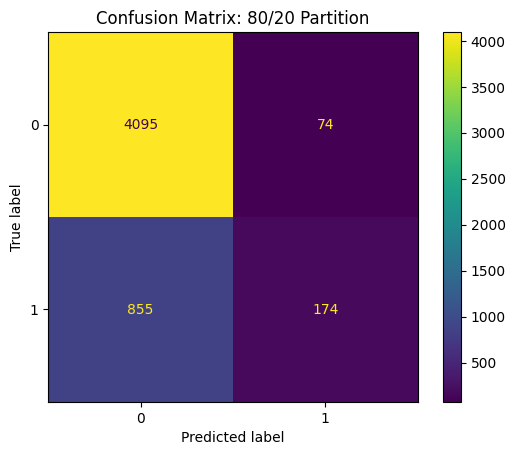


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.845106       0.861538
1     50/50     0.841739       0.826100
2     80/20     0.828340       0.821277


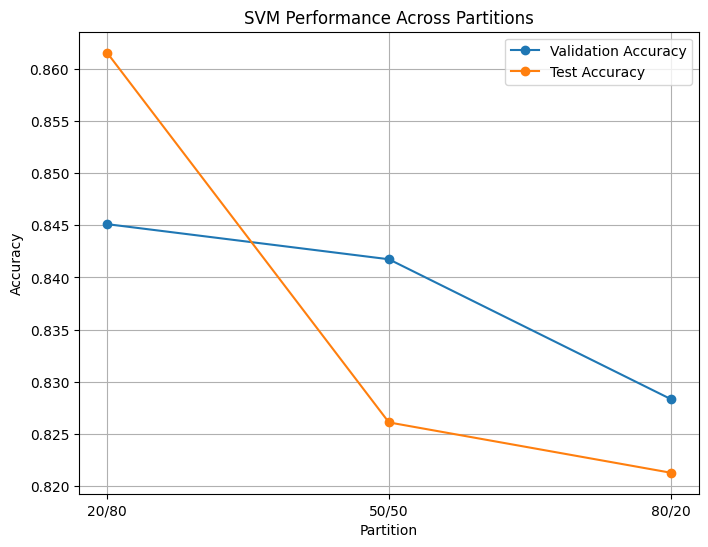

In [30]:
datasets = [
    {"name": "Adult Dataset", "data": adult_dataset, "target": "salary"},
    {"name": "Heart Dataset", "data": heart_dataset, "target": "severity"},
    {"name": "Red Wine Dataset", "data": red_wine_dataset, "target": "quality"},
    {"name": "White Wine Dataset", "data": white_wine_dataset, "target": "quality"},
    {"name": "Red and White Wine Dataset", "data": red_white_wine_dataset, "target": "quality"}
]

for i, dataset_info in enumerate(tqdm(datasets, desc="Datasets"), start=1):
    dataset_name = dataset_info["name"]
    dataset = dataset_info["data"]
    target_column = dataset_info["target"]
    print(f"\nTraining on '{dataset_name}' with target column '{target_column}'...")
    train_svm_with_partitions(dataset, target_column)

### SVM Analysis
type here

### Running random forest on all the datasets

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Average cross-validation accuracy: 0.85
Test accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4503
           1       0.78      0.61      0.69      1530

    accuracy                           0.86      6033
   macro avg       0.83      0.78      0.80      6033
weighted avg       0.85      0.86      0.85      6033



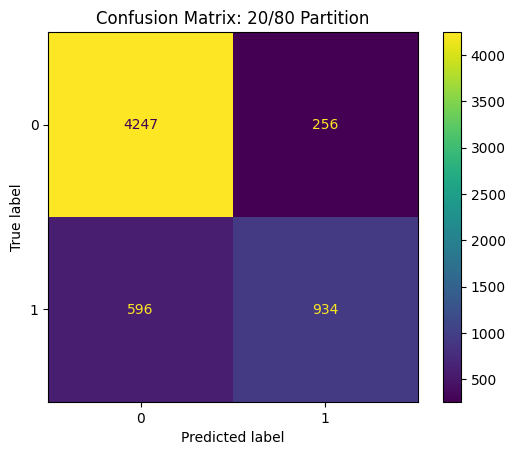


Training with 50/50 partition...
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Average cross-validation accuracy: 0.85
Test accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     11287
           1       0.77      0.60      0.68      3794

    accuracy                           0.86     15081
   macro avg       0.83      0.77      0.79     15081
weighted avg       0.85      0.86      0.85     15081



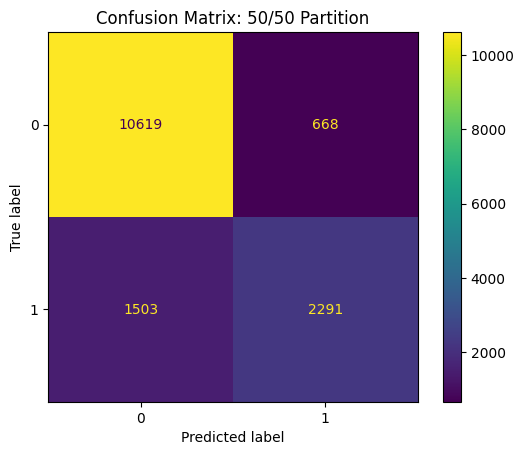


Training with 80/20 partition...
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Average cross-validation accuracy: 0.85
Test accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     18144
           1       0.75      0.60      0.67      5986

    accuracy                           0.85     24130
   macro avg       0.81      0.77      0.79     24130
weighted avg       0.85      0.85      0.85     24130



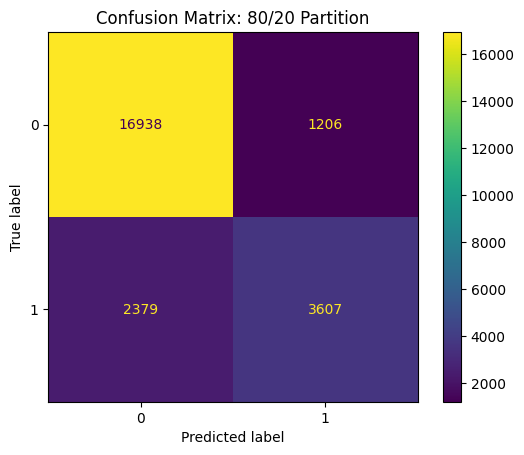


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.854366       0.858777
1     50/50     0.854121       0.856044
2     80/20     0.853943       0.851430


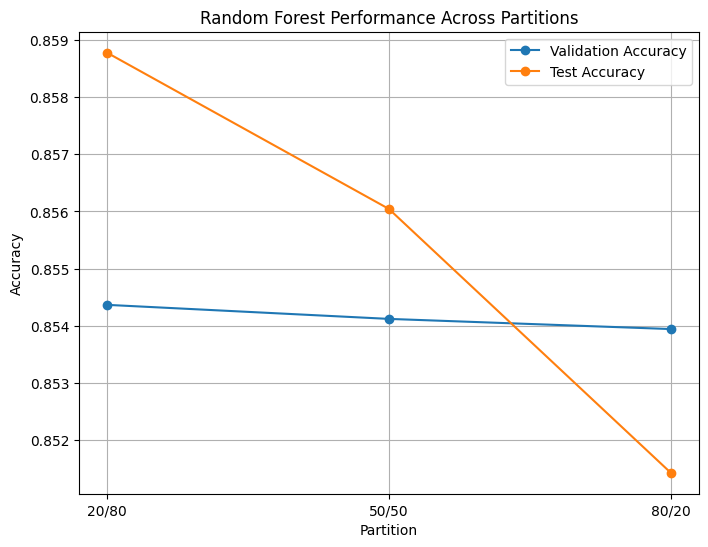


Training on 'Heart Dataset' with target column 'severity'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Average cross-validation accuracy: 0.81
Test accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.80      0.83      0.82        24

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.84        60
weighted avg       0.85      0.85      0.85        60



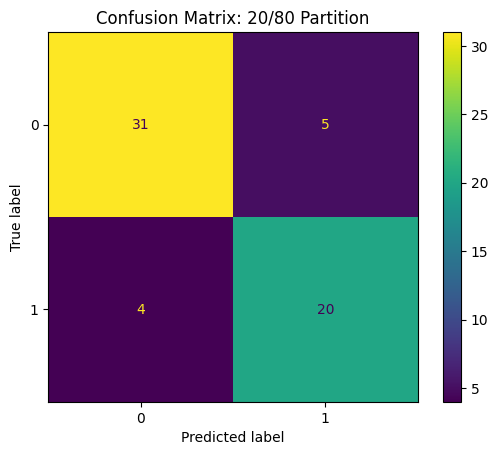


Training with 50/50 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Average cross-validation accuracy: 0.84
Test accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        70
           1       0.87      0.68      0.77        79

    accuracy                           0.78       149
   macro avg       0.79      0.78      0.78       149
weighted avg       0.80      0.78      0.78       149



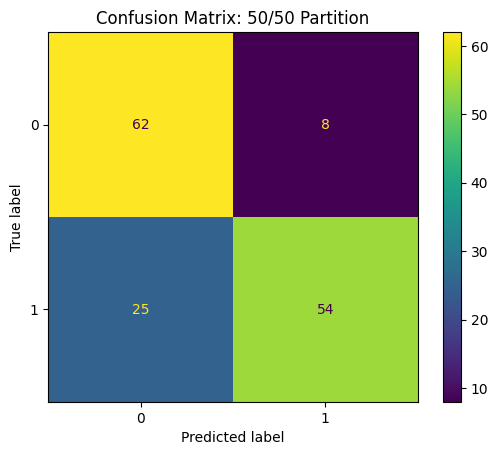


Training with 80/20 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Average cross-validation accuracy: 0.86
Test accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.94      0.79       121
           1       0.90      0.55      0.68       117

    accuracy                           0.75       238
   macro avg       0.79      0.74      0.74       238
weighted avg       0.79      0.75      0.74       238



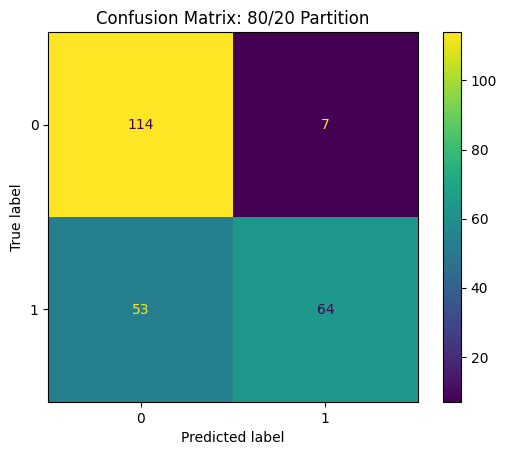


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.810018       0.850000
1     50/50     0.837471       0.778523
2     80/20     0.862121       0.747899


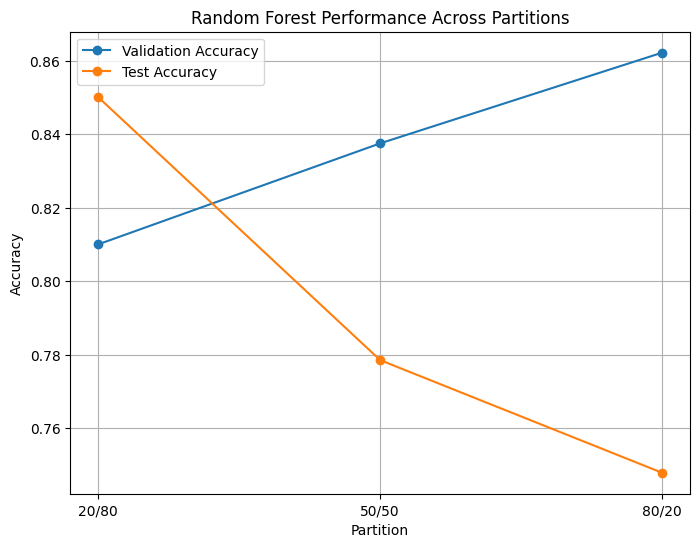


Training on 'Red Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Average cross-validation accuracy: 0.91
Test accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       273
           1       0.74      0.53      0.62        47

    accuracy                           0.90       320
   macro avg       0.83      0.75      0.78       320
weighted avg       0.90      0.90      0.90       320



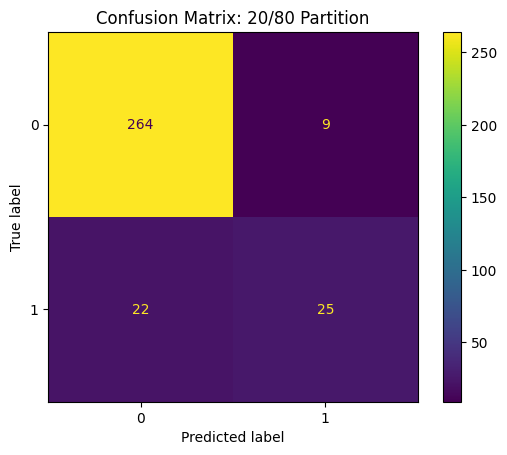


Training with 50/50 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Average cross-validation accuracy: 0.90
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       688
           1       0.68      0.40      0.51       112

    accuracy                           0.89       800
   macro avg       0.80      0.69      0.72       800
weighted avg       0.88      0.89      0.88       800



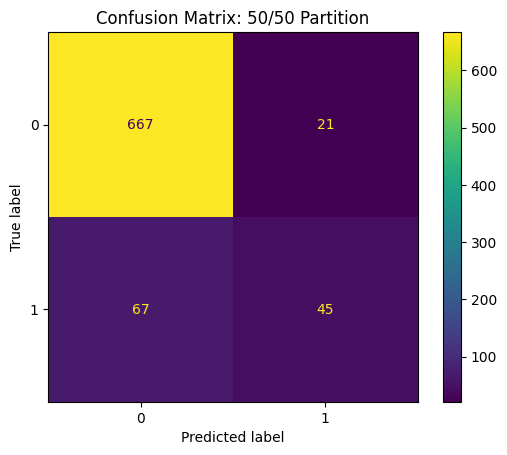


Training with 80/20 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Average cross-validation accuracy: 0.92
Test accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1102
           1       0.64      0.24      0.34       178

    accuracy                           0.88      1280
   macro avg       0.76      0.61      0.64      1280
weighted avg       0.85      0.88      0.85      1280



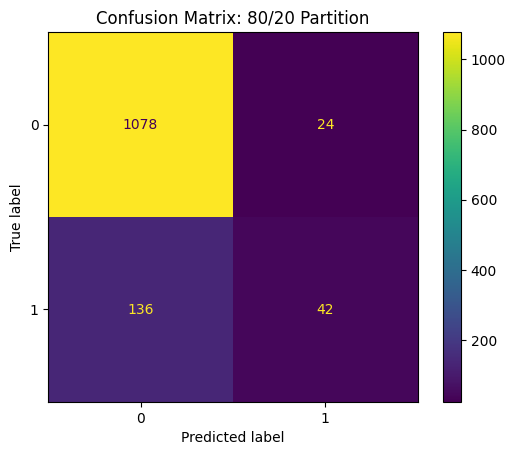


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.909320       0.903125
1     50/50     0.902398       0.890000
2     80/20     0.918552       0.875000


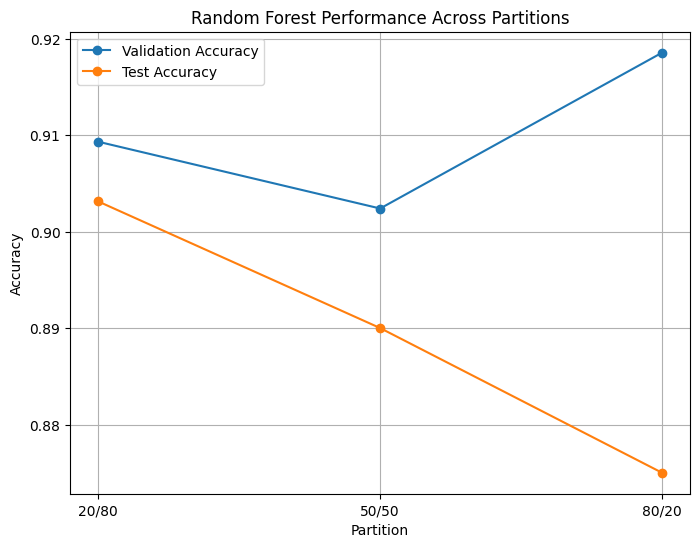


Training on 'White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Average cross-validation accuracy: 0.87
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       753
           1       0.83      0.67      0.74       227

    accuracy                           0.89       980
   macro avg       0.87      0.82      0.84       980
weighted avg       0.89      0.89      0.89       980



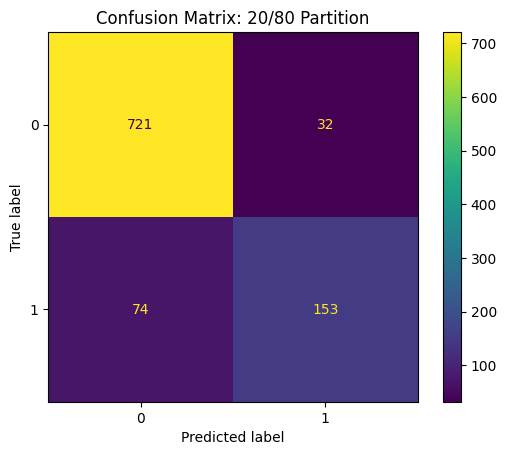


Training with 50/50 partition...
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Average cross-validation accuracy: 0.85
Test accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1888
           1       0.80      0.52      0.63       561

    accuracy                           0.86      2449
   macro avg       0.84      0.74      0.77      2449
weighted avg       0.86      0.86      0.85      2449



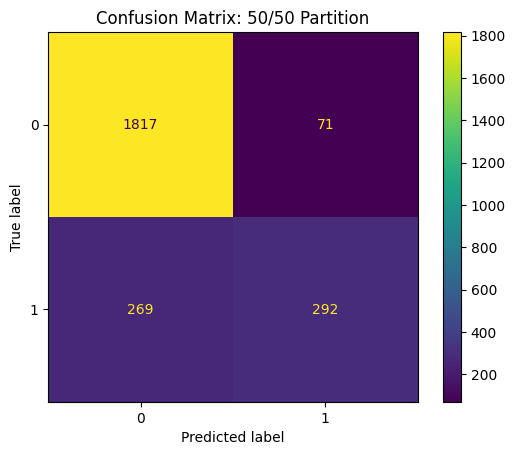


Training with 80/20 partition...
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Average cross-validation accuracy: 0.83
Test accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3055
           1       0.72      0.34      0.46       864

    accuracy                           0.83      3919
   macro avg       0.78      0.65      0.68      3919
weighted avg       0.81      0.83      0.80      3919



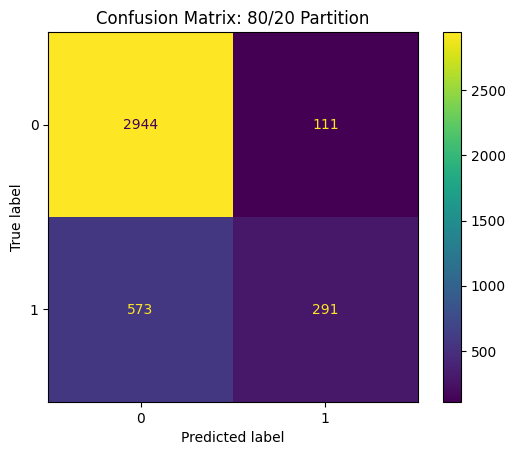


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.873655       0.891837
1     50/50     0.848926       0.861168
2     80/20     0.827425       0.825466


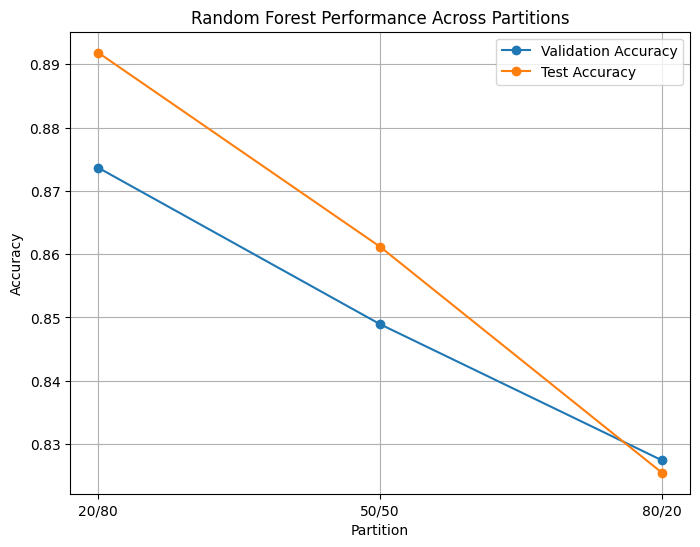


Training on 'Red and White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Average cross-validation accuracy: 0.88
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1048
           1       0.78      0.58      0.66       252

    accuracy                           0.89      1300
   macro avg       0.84      0.77      0.80      1300
weighted avg       0.88      0.89      0.88      1300



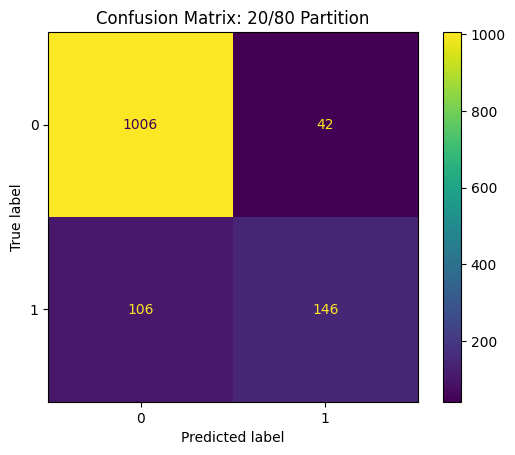


Training with 50/50 partition...
Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Average cross-validation accuracy: 0.87
Test accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2613
           1       0.75      0.47      0.58       636

    accuracy                           0.87      3249
   macro avg       0.82      0.72      0.75      3249
weighted avg       0.86      0.87      0.85      3249



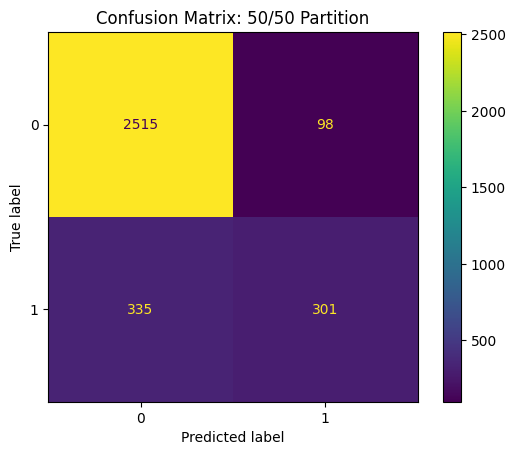


Training with 80/20 partition...
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Average cross-validation accuracy: 0.85
Test accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4169
           1       0.72      0.35      0.47      1029

    accuracy                           0.84      5198
   macro avg       0.79      0.66      0.69      5198
weighted avg       0.83      0.84      0.82      5198



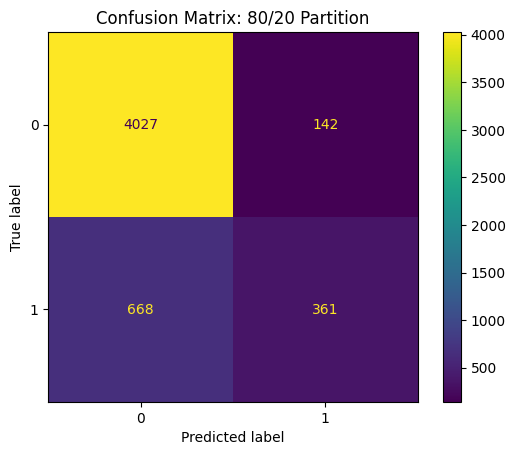


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.882627       0.886154
1     50/50     0.872536       0.866728
2     80/20     0.852961       0.844171


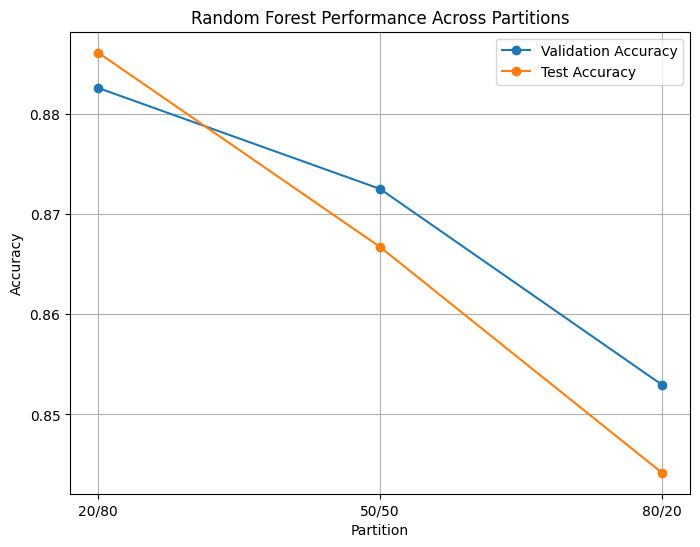

In [31]:
datasets = [
    {"name": "Adult Dataset", "data": adult_dataset, "target": "salary"},
    {"name": "Heart Dataset", "data": heart_dataset, "target": "severity"},
    {"name": "Red Wine Dataset", "data": red_wine_dataset, "target": "quality"},
    {"name": "White Wine Dataset", "data": white_wine_dataset, "target": "quality"},
    {"name": "Red and White Wine Dataset", "data": red_white_wine_dataset, "target": "quality"}
]

for i, dataset_info in enumerate(tqdm(datasets, desc="Datasets"), start=1):
    dataset_name = dataset_info["name"]
    dataset = dataset_info["data"]
    target_column = dataset_info["target"]
    print(f"\nTraining on '{dataset_name}' with target column '{target_column}'...")
    train_random_forest_with_partitions(dataset, target_column)

### Random Forest Analysis
type here

### Running logistic regression on all the datasets

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4503
           1       0.72      0.59      0.65      1530

    accuracy                           0.84      6033
   macro avg       0.79      0.75      0.77      6033
weighted avg       0.83      0.84      0.83      6033



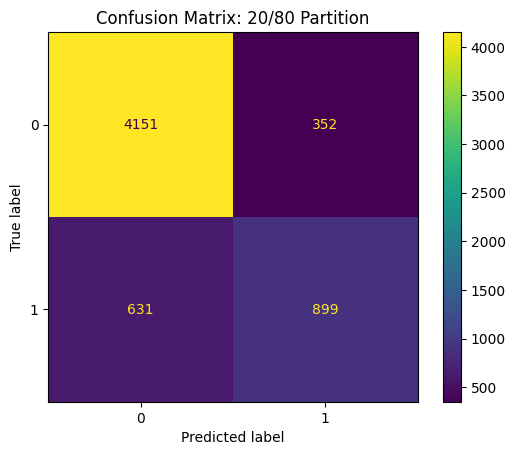


Training with 50/50 partition...
Best parameters: {'C': 1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}
Average cross-validation accuracy: 0.84
Test accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     11287
           1       0.70      0.59      0.64      3794

    accuracy                           0.83     15081
   macro avg       0.79      0.75      0.77     15081
weighted avg       0.83      0.83      0.83     15081



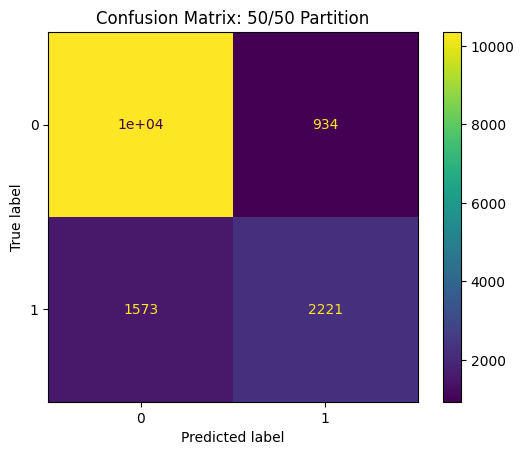


Training with 80/20 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Average cross-validation accuracy: 0.83
Test accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     18144
           1       0.69      0.60      0.64      5986

    accuracy                           0.83     24130
   macro avg       0.78      0.75      0.77     24130
weighted avg       0.83      0.83      0.83     24130



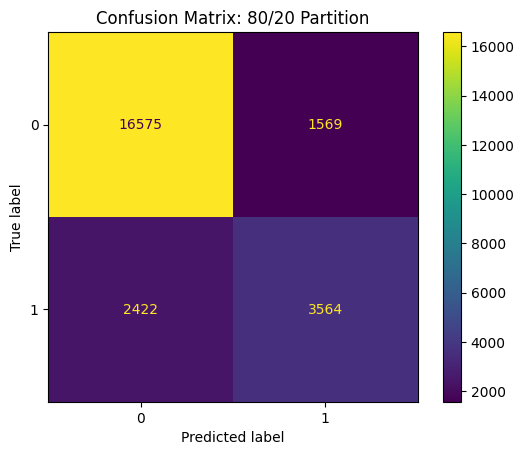


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.835261       0.837063
1     50/50     0.835620       0.833764
2     80/20     0.834879       0.834604


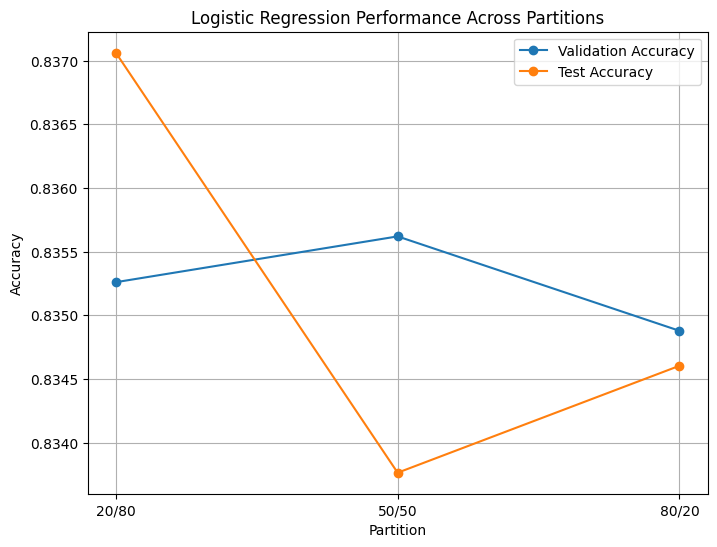


Training on 'Heart Dataset' with target column 'severity'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.85      0.92      0.88        24

    accuracy                           0.90        60
   macro avg       0.89      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



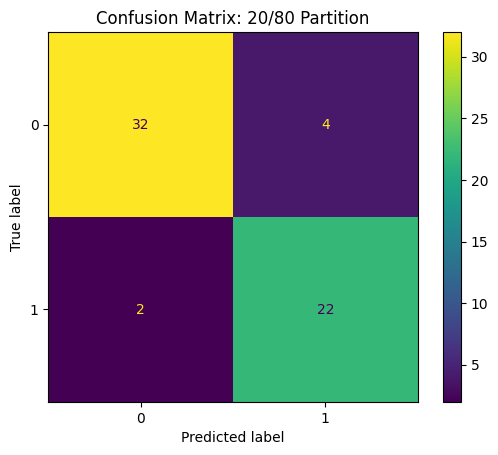


Training with 50/50 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.86
Test accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        70
           1       0.87      0.76      0.81        79

    accuracy                           0.81       149
   macro avg       0.82      0.82      0.81       149
weighted avg       0.82      0.81      0.81       149



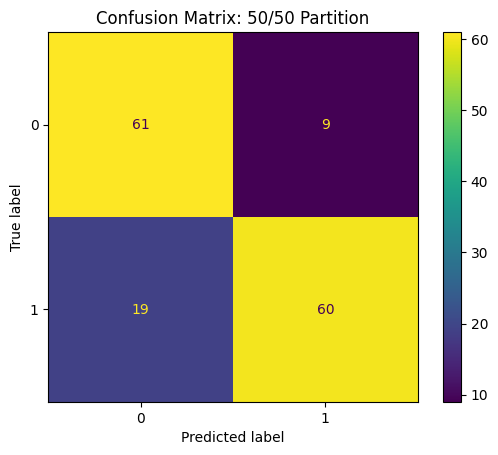


Training with 80/20 partition...
Best parameters: {'C': 0.1, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.85
Test accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       121
           1       0.82      0.81      0.82       117

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238



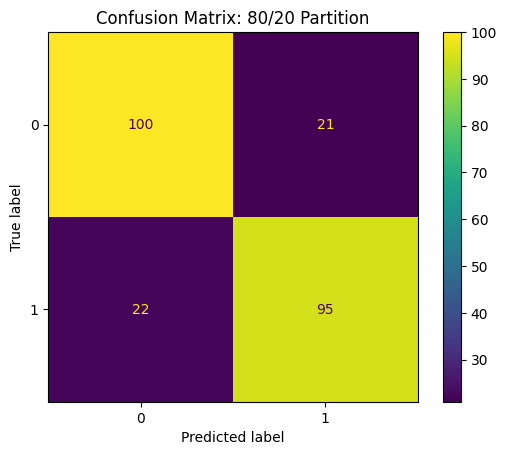


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.822784       0.900000
1     50/50     0.857701       0.812081
2     80/20     0.846970       0.819328


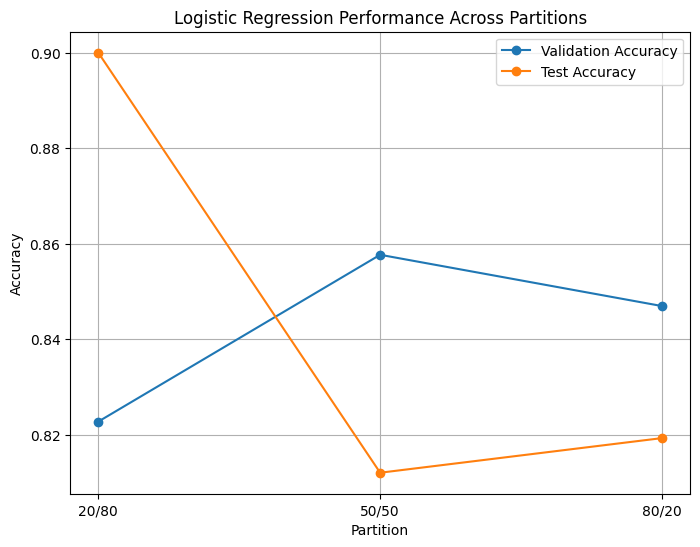


Training on 'Red Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 10, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Average cross-validation accuracy: 0.89
Test accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       273
           1       0.57      0.28      0.37        47

    accuracy                           0.86       320
   macro avg       0.73      0.62      0.65       320
weighted avg       0.84      0.86      0.84       320



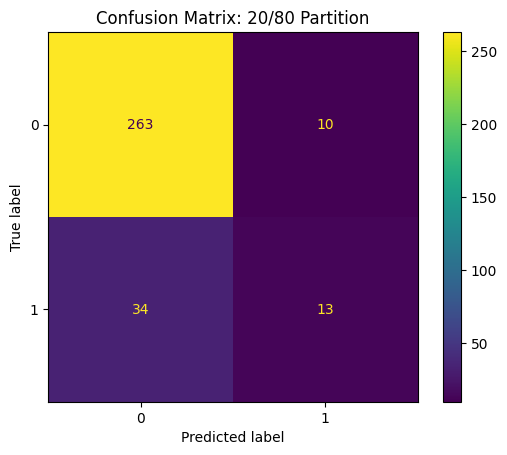


Training with 50/50 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.88
Test accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       688
           1       0.63      0.26      0.37       112

    accuracy                           0.88       800
   macro avg       0.76      0.62      0.65       800
weighted avg       0.85      0.88      0.85       800



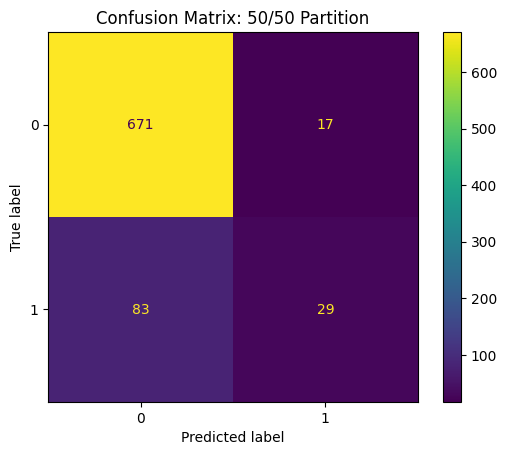


Training with 80/20 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.89
Test accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1102
           1       0.55      0.16      0.24       178

    accuracy                           0.86      1280
   macro avg       0.71      0.57      0.59      1280
weighted avg       0.83      0.86      0.83      1280



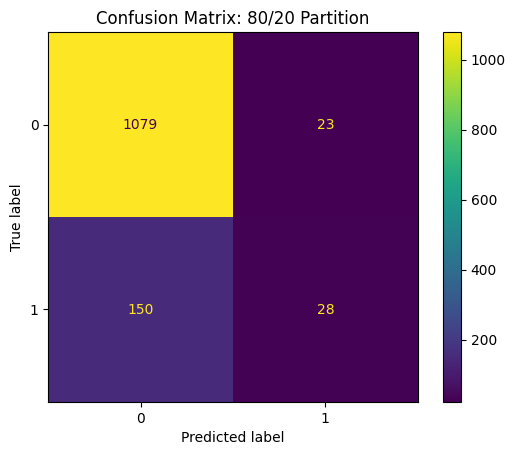


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.886636       0.862500
1     50/50     0.884866       0.875000
2     80/20     0.887202       0.864844


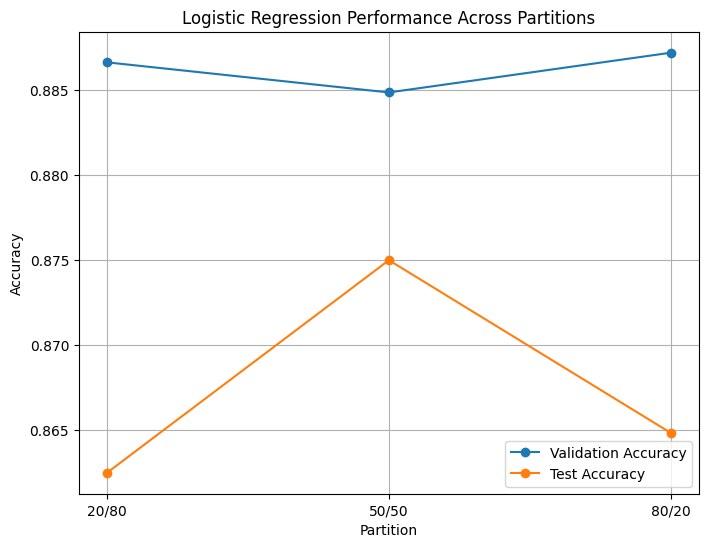


Training on 'White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Average cross-validation accuracy: 0.81
Test accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       753
           1       0.59      0.25      0.35       227

    accuracy                           0.79       980
   macro avg       0.70      0.60      0.61       980
weighted avg       0.76      0.79      0.75       980



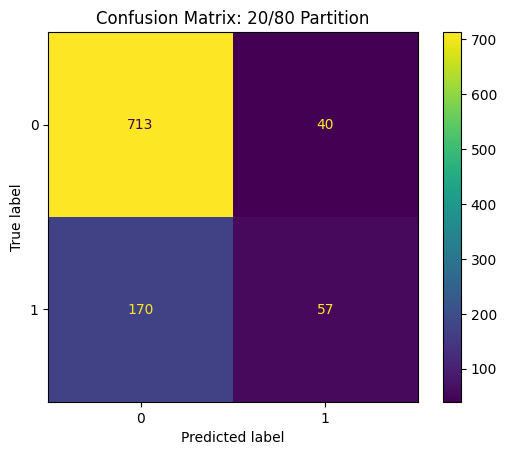


Training with 50/50 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1888
           1       0.61      0.23      0.33       561

    accuracy                           0.79      2449
   macro avg       0.71      0.59      0.60      2449
weighted avg       0.76      0.79      0.75      2449



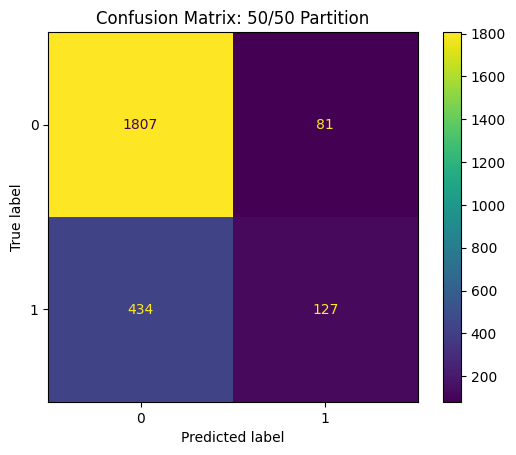


Training with 80/20 partition...
Best parameters: {'C': 10, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3055
           1       0.59      0.27      0.37       864

    accuracy                           0.80      3919
   macro avg       0.71      0.61      0.63      3919
weighted avg       0.77      0.80      0.77      3919



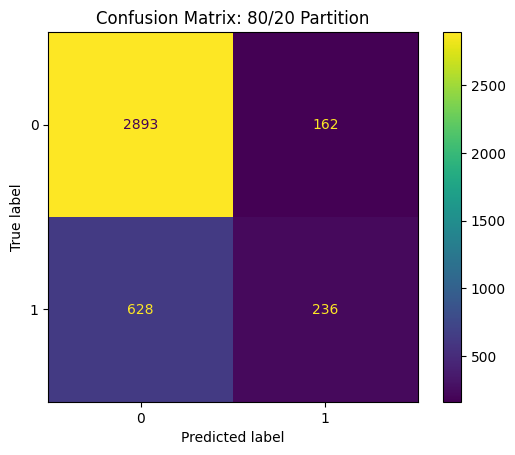


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.807809       0.785714
1     50/50     0.819932       0.789710
2     80/20     0.821266       0.798418


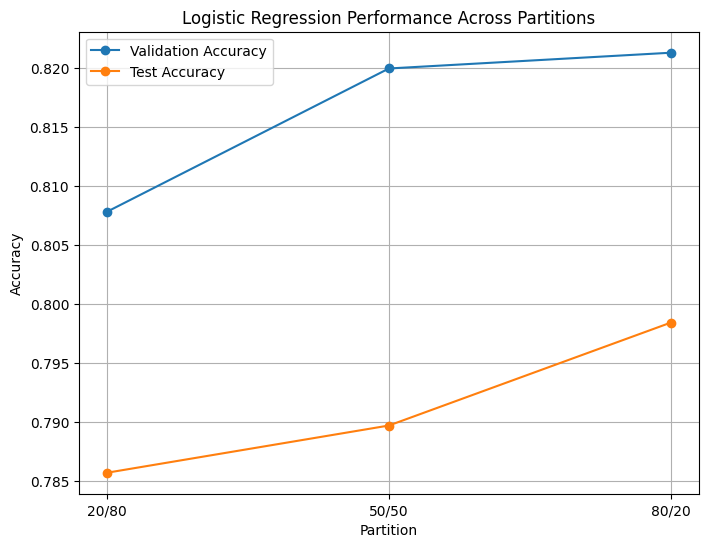


Training on 'Red and White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Training with 20/80 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1048
           1       0.63      0.26      0.37       252

    accuracy                           0.83      1300
   macro avg       0.74      0.61      0.63      1300
weighted avg       0.80      0.83      0.80      1300



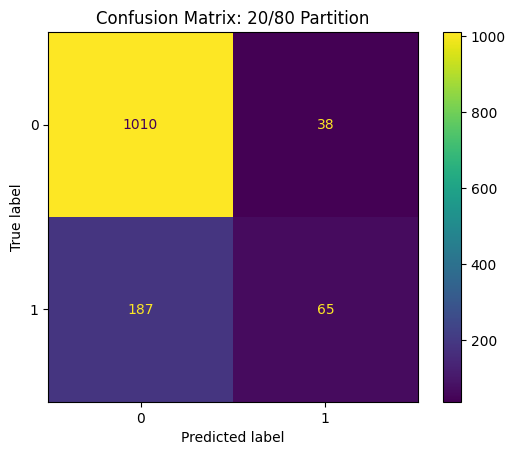


Training with 50/50 partition...
Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      2613
           1       0.59      0.26      0.36       636

    accuracy                           0.82      3249
   macro avg       0.71      0.61      0.63      3249
weighted avg       0.79      0.82      0.79      3249



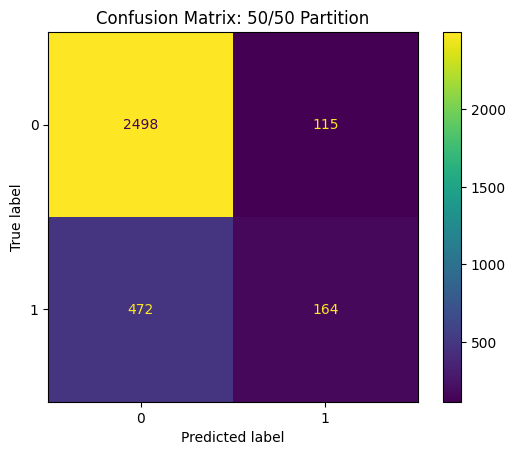


Training with 80/20 partition...
Best parameters: {'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Average cross-validation accuracy: 0.82
Test accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      4169
           1       0.59      0.21      0.31      1029

    accuracy                           0.82      5198
   macro avg       0.71      0.59      0.60      5198
weighted avg       0.78      0.82      0.78      5198



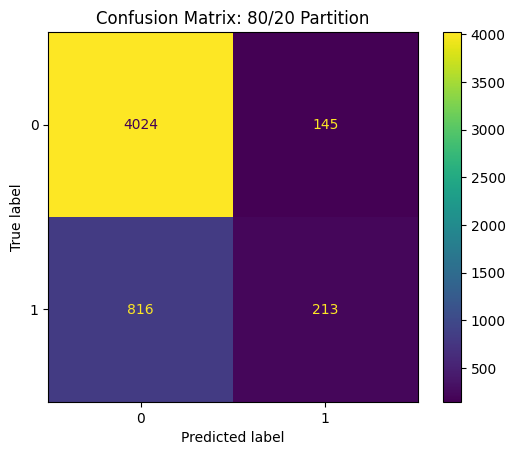


Summary of Results:
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.816240       0.826923
1     50/50     0.818348       0.819329
2     80/20     0.819118       0.815121


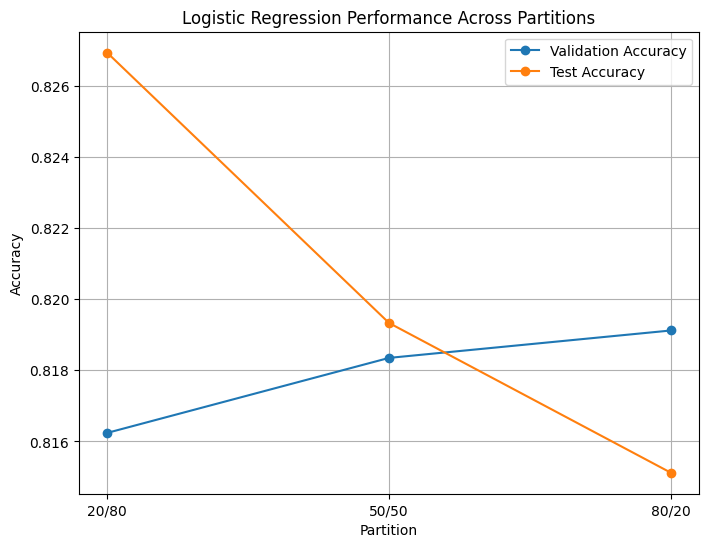

In [32]:
datasets = [
    {"name": "Adult Dataset", "data": adult_dataset, "target": "salary"},
    {"name": "Heart Dataset", "data": heart_dataset, "target": "severity"},
    {"name": "Red Wine Dataset", "data": red_wine_dataset, "target": "quality"},
    {"name": "White Wine Dataset", "data": white_wine_dataset, "target": "quality"},
    {"name": "Red and White Wine Dataset", "data": red_white_wine_dataset, "target": "quality"}
]

for i, dataset_info in enumerate(tqdm(datasets, desc="Datasets"), start=1):
    dataset_name = dataset_info["name"]
    dataset = dataset_info["data"]
    target_column = dataset_info["target"]
    print(f"\nTraining on '{dataset_name}' with target column '{target_column}'...")
    train_logistic_regression_with_partitions(dataset, target_column)

### Logistic Regression Analysis
type here